In [1]:
import jax
jax.config.update('jax_enable_x64', True)
import jax.numpy as jnp
from jax import grad, jacobian, vmap, random, hessian
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc


In [2]:
def lap(f, argnums):
    def laplacian(x, y):
        return - jnp.trace(hessian(f, argnums=argnums)(x, y))
    return laplacian

def rbf(gamma):
    def kernel(x, y):
        return jnp.exp(-gamma*jnp.sum((x-y)**2))
    return kernel

k = rbf(4)

vec_k = vmap(vmap(k, (None, 0)), (0, None)) 

lapx = lap(k, argnums=0) # laplacian wrt to first input x
lapx_lapy = lap(lapx, argnums=1) # laplacian wrt to second input y
vec_lapx = vmap(vmap(lapx, in_axes = (None,0)), in_axes=(0, None)) 
vec_lapx_lapy = vmap(vmap(lapx_lapy, in_axes = (None,0)), in_axes = (0, None))

In [3]:
def u_exact(x, y):
    return -jnp.sin(jnp.pi * x) * jnp.sin(jnp.pi * y)

def f(x, y):
    def u(xy):
        return u_exact(xy[0], xy[1])
    laplacian = - jnp.trace(hessian(u)(jnp.array([x, y]))) 
    return laplacian

def g_dir(x, y):
    return u_exact(x, y)

f_vec = vmap(f, in_axes=(0, 0))
g_dir_vec = vmap(g_dir, in_axes=(0, 0))


In [4]:
def uniform_points(xmin, xmax, ymin, ymax, Nx, Ny):
    dx = (xmax - xmin)/ (Nx - 1)
    dy = (ymax - ymin)/ (Ny - 1)

    x_int = jnp.linspace(xmin + dx, xmax - dx, Nx - 2)
    y_int = jnp.linspace(ymin + dy, ymax - dx, Ny - 2)
    X_int = jnp.stack(jnp.meshgrid(x_int, y_int), axis=-1).reshape(-1, 2)

    x_b = jnp.linspace(xmin, xmax, Nx)
    y_b = jnp.linspace(ymin, ymax, Ny)


    # Four edges
    bottom = jnp.stack([x_b[:-1], jnp.full_like(x_b[:-1], ymin)], axis=1)
    top    = jnp.stack([x_b[1:], jnp.full_like(x_b[1:], ymax)], axis=1)
    left   = jnp.stack([jnp.full_like(y_b[1:], xmin), y_b[1:]], axis=1)
    right  = jnp.stack([jnp.full_like(y_b[:-1], xmax), y_b[:-1]], axis=1)

    X_bdy = jnp.concatenate([bottom, top, right, left], axis=0)

    return X_int, X_bdy

def random_points(xmin, xmax, ymin, ymax, I, B):
    key1 = random.PRNGKey(0)
    key2 = random.PRNGKey(1)
    X_int = random.uniform(key1, shape=(I, 2), minval=jnp.array([xmin, ymin]), maxval=jnp.array([xmax, ymax]))
    # x_bd = jnp.concatenate((random.bernoulli(key1, p=0.5, shape=(B//2, 1)), random.uniform(key2, shape=(B//2, 1), minval=ymin, maxval=ymax)), axis=1)
    # y_bd = jnp.concatenate((random.uniform(key1, shape=(B//2, 1), minval=xmin, maxval=xmax ), random.bernoulli(key2, p=0.5, shape=(B//2, 1))), axis=1)

    x_choices = random.randint(key1, shape=(B//2, 1), minval=0, maxval=2)
    x_fixed = jnp.where(x_choices == 0, xmin, xmax)
    y_rand = random.uniform(key2, shape=(B//2, 1), minval=ymin, maxval=ymax)
    x_bd = jnp.concatenate((x_fixed, y_rand), axis=1)

    # y-boundary: y = ymin or ymax, x ∈ [xmin, xmax]
    key3, key4 = random.split(key2)
    y_choices = random.randint(key3, shape=(B//2, 1), minval=0, maxval=2)
    y_fixed = jnp.where(y_choices == 0, ymin, ymax)
    x_rand = random.uniform(key4, shape=(B//2, 1), minval=xmin, maxval=xmax)
    y_bd = jnp.concatenate((x_rand, y_fixed), axis=1)
    X_bdy  = jnp.concatenate((x_bd, y_bd), axis=0)

    return X_int, X_bdy

def sobol_points(xmin, xmax, ymin, ymax, I, B):
    sampler1 = qmc.Sobol(d=1, scramble=True)
    sampler2 = qmc.Sobol(d=2, scramble=True)
    x_b1 = sampler1.random(n=B//4)
    x_b1 = x_b1.flatten()
    x_b1 = xmin + (xmax - xmin)*x_b1
    x_b2 = sampler1.random(n=B//4)
    x_b2 = x_b2.flatten()
    x_b2 = xmin + (xmax - xmin)*x_b2
    x_b3 = sampler1.random(n=B//4)
    x_b3 = x_b3.flatten()
    x_b3 = xmin + (xmax - xmin)*x_b3
    x_b4 = sampler1.random(n=B//4)
    x_b4 = x_b4.flatten()
    x_b4 = xmin + (xmax - xmin)*x_b4

    X_int = sampler2.random(n=I)
    bottom = jnp.stack([x_b1, jnp.full_like(x_b1, ymin)], axis=1)
    top    = jnp.stack([x_b2, jnp.full_like(x_b2, ymax)], axis=1)
    left   = jnp.stack([jnp.full_like(x_b3, xmin), x_b3], axis=1)

    right  = jnp.stack([jnp.full_like(x_b3, xmax), x_b3], axis=1)

    X_bdy = jnp.concatenate([bottom, top, right, left], axis=0)
    X_int = xmin + (xmax - xmin)*X_int

    return X_int, X_bdy

    
I = 50  # num interior points
B = 20   # num boundary points

xmin, xmax = 0, 1
ymin, ymax = 0, 1

X_int_u, X_bdy_u = uniform_points(xmin, xmax, ymin, ymax, 9, 9)
X_int_r, X_bdy_r = random_points(xmin, xmax, ymin, ymax, I, B)
X_int_s, X_bdy_s = sobol_points(xmin, xmax, ymin, ymax, I, B)

# Plot
# fig, axs = plt.subplots(1, 3, figsize=(17, 5))
# sc = axs[0].scatter(X_int_u[:, 0], X_int_u[:,1])
# sc = axs[0].scatter(X_bdy_u[:, 0], X_bdy_u[:,1])

# sc = axs[1].scatter(X_int_r[:, 0], X_int_r[:,1])
# sc = axs[1].scatter(X_bdy_r[:, 0], X_bdy_r[:,1])

# sc = axs[2].scatter(X_int_s[:, 0], X_int_s[:,1])
# sc = axs[2].scatter(X_bdy_s[:, 0], X_bdy_s[:,1])


c:\Users\rvang\anaconda3\Lib\site-packages\scipy\stats\_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


In [5]:
def u_est(X_int, X_bdy):
    K_11 = vec_lapx_lapy(X_int, X_int)
    K_12 = vec_lapx(X_int, X_bdy)
    K_21 = jnp.copy(K_12).T
    K_22 = vec_k(X_bdy, X_bdy)

    K = jnp.block([
        [K_11, K_12],
        [K_21, K_22]
        ])
    
    f_int = f_vec(X_int[:,0], X_int[:,1])  
    g_bdy = g_dir_vec(X_bdy[:,0], X_bdy[:,1]) 
    f_rhs = jnp.hstack([f_int, g_bdy])
    alpha = jnp.linalg.solve(K + 1e-9*jnp.eye(K.shape[0]), f_rhs)
    def u_grid(x):
        basis = jnp.hstack([vec_lapx(x.reshape(1, -1), X_int), vec_k(x.reshape(1, -1), X_bdy)])
        return (basis @ alpha).squeeze()
    return u_grid


In [6]:
u_u = u_est(X_int_u, X_bdy_u)
u_r = u_est(X_int_r, X_bdy_r)
u_s = u_est(X_int_s, X_bdy_s)

vec_u_u = vmap(u_u, in_axes=0)
vec_u_r = vmap(u_r, in_axes=0)
vec_u_s = vmap(u_s, in_axes=0)

In [ ]:
def check_lap(u):
    def lap(x):
        return -jnp.trace(hessian(u)(x))
    return vmap(lap, in_axes=0)

n_eval = 100
x, y = jnp.linspace(xmin, xmax, n_eval), jnp.linspace(ymin, ymax, n_eval)
X, Y = jnp.meshgrid(x, y)

X_test = jnp.concatenate((X.reshape(-1, 1), Y.reshape(-1, 1)), axis=1)

uu_est = vec_u_u(X_test)
ur_est = vec_u_r(X_test)
us_est = vec_u_s(X_test)

lap_u_u = check_lap(u_u)
lap_uu_test = lap_u_u(X_test)

lap_u_r = check_lap(u_r)
lap_ur_test = lap_u_r(X_test)

lap_u_s = check_lap(u_s)
lap_us_test = lap_u_s(X_test)

In [ ]:
f_exact = f_vec(X_test[:, 0], X_test[:, 1])
f_norm = np.linalg.norm(f_exact)
u_exact_test =  u_exact(X_test[:, 0], X_test[:, 1])
u_exact_norm = np.linalg.norm(u_exact_test)
print("Relative L-inf laplacian error:")
print("Random:  ", np.linalg.norm(lap_ur_test- f_exact)/f_norm) #random
print("Uniform: ", np.linalg.norm(lap_uu_test - f_exact)/f_norm) #uniform
print("Sobol:   ", np.linalg.norm(lap_us_test- f_exact)/f_norm) #sobol
print("Relative L-inf solution error:")
print("Random:  ", np.max(np.abs(ur_est - u_exact_test))/u_exact_norm) #random
print("Uniform: ", np.max(np.abs(uu_est - u_exact_test))/u_exact_norm) #uniform
print("Sobol:   ", np.max(np.abs(us_est - u_exact_test))/u_exact_norm) #sobol


Relative L-inf laplacian error:
Random:   0.007153026493637995
Uniform:  0.008354963247422652
Sobol:    0.0051085742219402165
Relative L-inf solution error:
Random:   0.00027304036366479126
Uniform:  7.1575477255888496e-06
Sobol:    1.7573738384230548e-05


In [ ]:
lap_u_coll_s = lap_u_s(X_int_s)
print(np.max(lap_u_coll_s - f_vec(X_int_s[:, 0], X_int_s[:, 1])))

2.5221396526831086e-08


(0.0, 1.0)

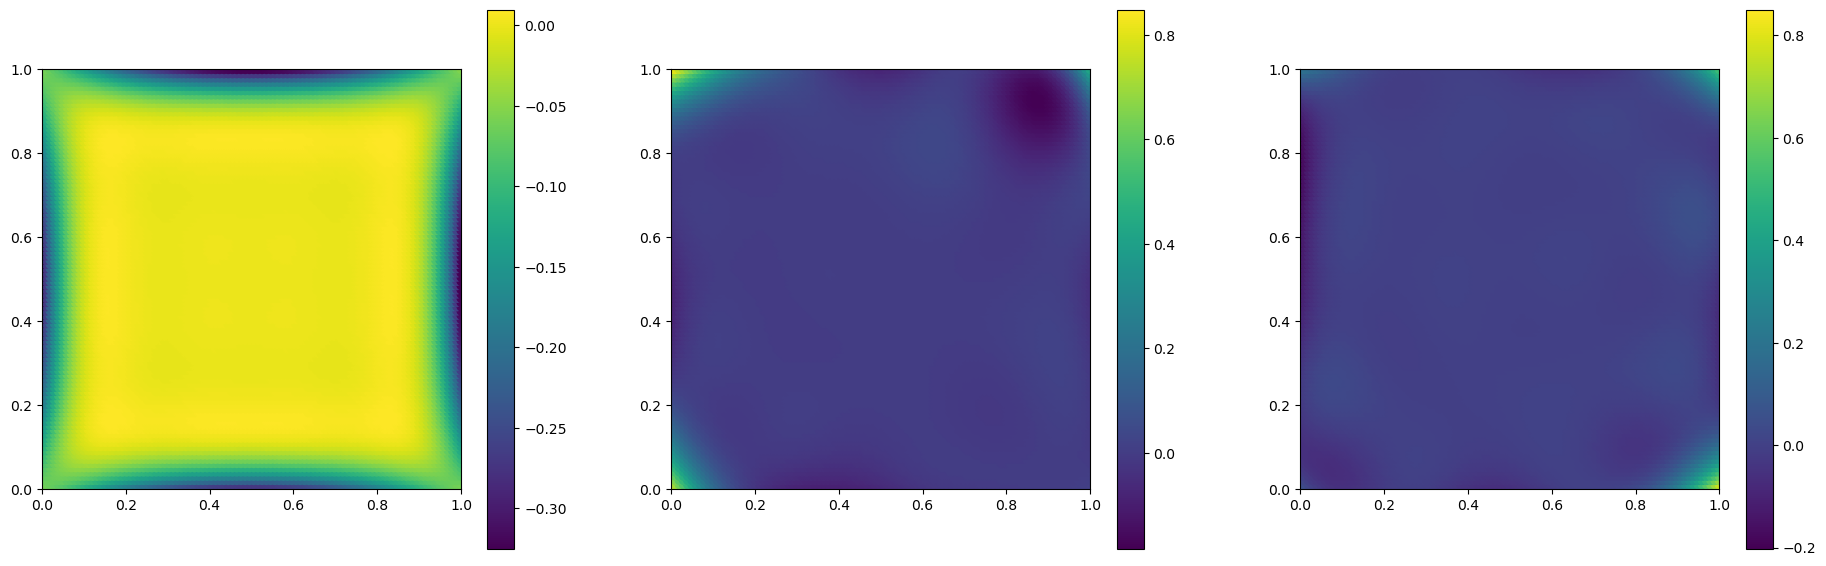

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(23, 7))
sc = axs[0].scatter(X_test[:, 0], X_test[:,1], c=(f_vec(X_test[:,0], X_test[:, 1]) - lap_uu_test))
cb0 = fig.colorbar(sc, ax=axs[0]) 

sc2 = axs[1].scatter(X_test[:, 0], X_test[:,1], c=(f_vec(X_test[:,0], X_test[:, 1]) - lap_ur_test))
cb1 = fig.colorbar(sc2, ax=axs[1]) 

cf = axs[2].scatter(X_test[:, 0], X_test[:,1], c= (f_vec(X_test[:,0], X_test[:, 1]) - lap_us_test))
cb2 = fig.colorbar(cf, ax=axs[2]) 
axs[0].set_aspect('equal', 'box')
axs[1].set_aspect('equal', 'box')
axs[2].set_aspect('equal', 'box')

axs[0].set_xlim([x.min(), x.max()])
axs[0].set_ylim([y.min(), y.max()])
axs[1].set_xlim([x.min(), x.max()])
axs[1].set_ylim([y.min(), y.max()])
axs[2].set_xlim([x.min(), x.max()])
axs[2].set_ylim([y.min(), y.max()])

(0.0, 1.0)

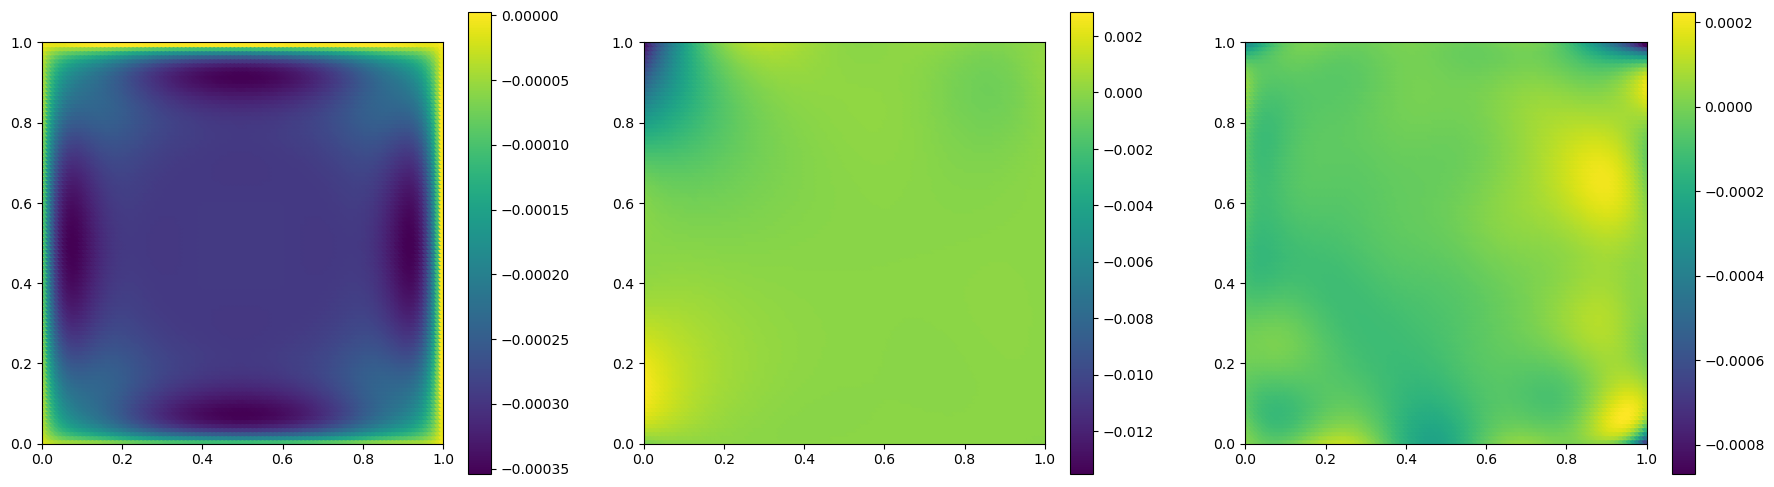

In [ ]:


fig, axs = plt.subplots(1, 3, figsize=(22, 6))
sc0 = axs[0].scatter(X_test[:, 0], X_test[:,1], c=(u_exact(X_test[:, 0], X_test[:, 1]) - uu_est))
cb0 = fig.colorbar(sc0, ax=axs[0])  
sc1 = axs[1].scatter(X_test[:, 0], X_test[:,1], c=(u_exact(X_test[:, 0], X_test[:, 1]) - ur_est))
cb1 = fig.colorbar(sc1, ax=axs[1])  
sc2 = axs[2].scatter(X_test[:, 0], X_test[:,1], c=(u_exact(X_test[:, 0], X_test[:, 1]) - us_est))
cb2 = fig.colorbar(sc2, ax=axs[2]) 
# sc = axs[0].scatter(X_int_u[:, 0], X_int_u[:,1])
# sc = axs[0].scatter(X_bdy_u[:, 0], X_bdy_u[:,1])

# sc = axs[1].scatter(X_int_r[:, 0], X_int_r[:,1])
# sc = axs[1].scatter(X_bdy_r[:, 0], X_bdy_r[:,1])

# sc = axs[2].scatter(X_int_s[:, 0], X_int_s[:,1])
# sc = axs[2].scatter(X_bdy_s[:, 0], X_bdy_s[:,1])
# Aspect ratio and limits
axs[0].set_aspect('equal', 'box')
axs[1].set_aspect('equal', 'box')
axs[2].set_aspect('equal', 'box')

axs[0].set_xlim([x.min(), x.max()])
axs[0].set_ylim([y.min(), y.max()])
axs[1].set_xlim([x.min(), x.max()])
axs[1].set_ylim([y.min(), y.max()])
axs[2].set_xlim([x.min(), x.max()])
axs[2].set_ylim([y.min(), y.max()])